Chris S. Castañeda-Barajas

Data Science 450: Deriving Knowledge from Data at Scale

July 14, 2016

# Assignment 1

Your task for this assignment:  Design a simple, low-cost sensor that can distinguish between red wine and white wine.

Your sensor must correctly distinguish between red and white wine for at least 95% of the samples in a set of 6497 test samples of red and white wine.

Your technology is capable of sensing the following wine attributes:

- Fixed acidity  -  Free sulphur dioxide
- Volatile acidity  -  Total sulphur dioxide
- Citric acid  -  Sulphates
- Residual sugar  -  pH
- Chlorides  - Alcohol
- Density

Tasks

1. Read WineQuality.pdf.
2. Use the RedWhiteWine.csv/arff file that is provided, and upload to Azure Machine Learning as a dataset
Note: If needed, remove the quality attribute, which you will not need for this assignment.
3. Build an experiment in Azure Machine Learning using Decision Trees or Logistic Regression.
    1. What is the percentage of correct classification results (using all attributes)?
    2. What is the percentage of correct classification results (using a subset of the attributes)?
    3. What is the AUC of your model?
4. What is your best AUC that you can achieve?
5. Which are the the minimum number of attributes? Why?


# Results

I built a logistic classifier to identify Red wine based on the data provided. When I fed all attributes into my model, I achieved an average accuracy of 90.2% with an the AUC for model being 0.995927681102002.

I expirmented with feeding just single addtribute into my logistic classifier and found that the using only the `total_sulfur_dioxide` attribute i was able to achieve an accuracy of 82.2% with an AUC for my model of 0.958570155121446.

## Setup environment & Define Helper Functions

In [75]:
library(verification)

NormalizeVector <- function ( v ){
  v.min <- min(v)
  v.max <- max(v)
  return( (v - v.min) / (v.max - v.min) )
}

ConfusionMatrix <- function (actuals, predictions, threshold) {
  # ---------------------------------------------------------------------------
  # Assumes that  `predictions` and `actuals` are in the same order and are the 
  # same length.
  #
  # ARGUMENTS:
  #   actuals: numeric vector of 1s and 0s
  #   predictions: numeric vector of probabilities ranging from 0.0 to 1.0, 
  #                some values may be NA
  #   threshold: numeric vector of at least length of 1, w/ values ranging from 
  #              0 to 1, ideally in a sequence/sorted
  #
  # RETURNS: dataframe w/ as many rows and `length(threshold)` 
  #          and five columns: threshold, TP, TN, FP, and FN
  # ---------------------------------------------------------------------------
  
  # Cache number of observations
  observations <- length(predictions)
  
  # Make sure threshold is in a sequence
  threshold <- sort(threshold)
  
  # Deal w/ null values in predictions
  predictions[is.na(predictions)] <- mean(predictions, na.rm=TRUE)
  
  confusion_matrix <- sapply(threshold, function(th) {
    p <- ifelse(predictions > th, 1, 0)
    # True Positives
    tp <- sapply(1:observations, function(i) as.numeric(actuals[i]==1 && p[i]==1))
    # True Negatives
    tn <- sapply(1:observations, function(i) as.numeric(actuals[i]==0 && p[i]==0))
    # False Positives
    fp <- sapply(1:observations, function(i) as.numeric(actuals[i]==0 && p[i]==1))
    # False Negatives
    fn <- sapply(1:observations, function(i) as.numeric(actuals[i]==1 && p[i]==0))
    return(c(th, sum(tp), sum(tn), sum(fp), sum(fn)))
  })
  
  df <- as.data.frame(t(confusion_matrix))
  names(df) <- c('threshold', 'TP', 'TN', 'FP', 'FN')
  
  return(df)
}

## Load Data

In [5]:
wineData <- read.csv('RedWhiteWine.csv', stringsAsFactors=TRUE)

In [6]:
wd.raw <- wineData  # cache raw data
wd.names <- names(wineData)
wd.names

[1] "fixed_acidity"        "volatile_acidity"     "citric_acid"         
 [4] "residual_sugar"       "chlorides"            "free_sulfur_dioxide" 
 [7] "total_sulfur_dioxide" "density"              "pH"                  
[10] "sulphates"            "alcohol"              "R_W"                 
[13] "quality"

## Clean Data

In [7]:
wd.norm <- wineData
wd.norm$fixed_acidity         <- NormalizeVector(wineData$fixed_acidity)
wd.norm$volatile_acidity      <- NormalizeVector(wineData$volatile_acidity)
wd.norm$citric_acid           <- NormalizeVector(wineData$citric_acid)
wd.norm$residual_sugar        <- NormalizeVector(wineData$residual_sugar)
wd.norm$chlorides             <- NormalizeVector(wineData$chlorides)
wd.norm$free_sulfur_dioxide   <- NormalizeVector(wineData$free_sulfur_dioxide)
wd.norm$total_sulfur_dioxide  <- NormalizeVector(wineData$total_sulfur_dioxide)
wd.norm$density               <- NormalizeVector(wineData$density)
wd.norm$pH                    <- NormalizeVector(wineData$pH)
wd.norm$sulphates             <- NormalizeVector(wineData$sulphates)
wd.norm$alcohol               <- NormalizeVector(wineData$alcohol)

In [8]:
wineData <- wd.norm

In [9]:
## Label Reds and Whites Individually
wineData$red <- wineData$R_W=='R'
wineData$white <- wineData$R_W=='W'
wineData = wineData[,c(-12, -13)]  # remove redundant R_W column, and quality

## Split Data into Training and Testing sets

In [10]:
## Chop up data for training and testing (use about 75% of data for training)
set.seed(2)
trainingIndicies <- as.logical(sample(0:1,nrow(wineData), replace=TRUE, prob=c(.25,.75)))
trainingData <- wineData[trainingIndicies, -13]  # col 12 is `red`, col 13 is `white`
testData <- wineData[!trainingIndicies, -13]

In [21]:
## Enumerate data attributes for reference later
data.frame(attributes=names(wineData[-13]))

,attributes
1,fixed_acidity
2,volatile_acidity
3,citric_acid
4,residual_sugar
5,chlorides
6,free_sulfur_dioxide
7,total_sulfur_dioxide
8,density
9,pH
10,sulphates


## Logistic Classifier

### Best AUC using just one attribute "total_sulfur_dioxide"

,threshold,TP,TN,FP,FN,accuracy
1,0,418,0,1256,0,0.2497013
2,0.1,396,975,281,22,0.8189964
3,0.2,378,1105,151,40,0.885902
4,0.3,356,1159,97,62,0.9050179
5,0.4,343,1191,65,75,0.916368
6,0.5,330,1215,41,88,0.9229391
7,0.6,313,1229,27,105,0.921147
8,0.7,294,1240,16,124,0.916368
9,0.8,255,1247,9,163,0.8972521
10,0.9,187,1251,5,231,0.8590203


[1] "Mean Accuracy: 0.822091886608016"

[1] "AUC: 0.958570155121446"

[1] "Summary of Model:"


Call:
glm(formula = red ~ ., family = binomial(link = "logit"), data = trainingData[, 
    training_attributes])

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.7633  -0.3335  -0.1036  -0.0061   5.0874  

Coefficients:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)            3.9824     0.1489   26.75   <2e-16 ***
total_sulfur_dioxide -27.0025     0.8259  -32.70   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 5369.2  on 4822  degrees of freedom
Residual deviance: 2138.1  on 4821  degrees of freedom
AIC: 2142.1

Number of Fisher Scoring iterations: 7


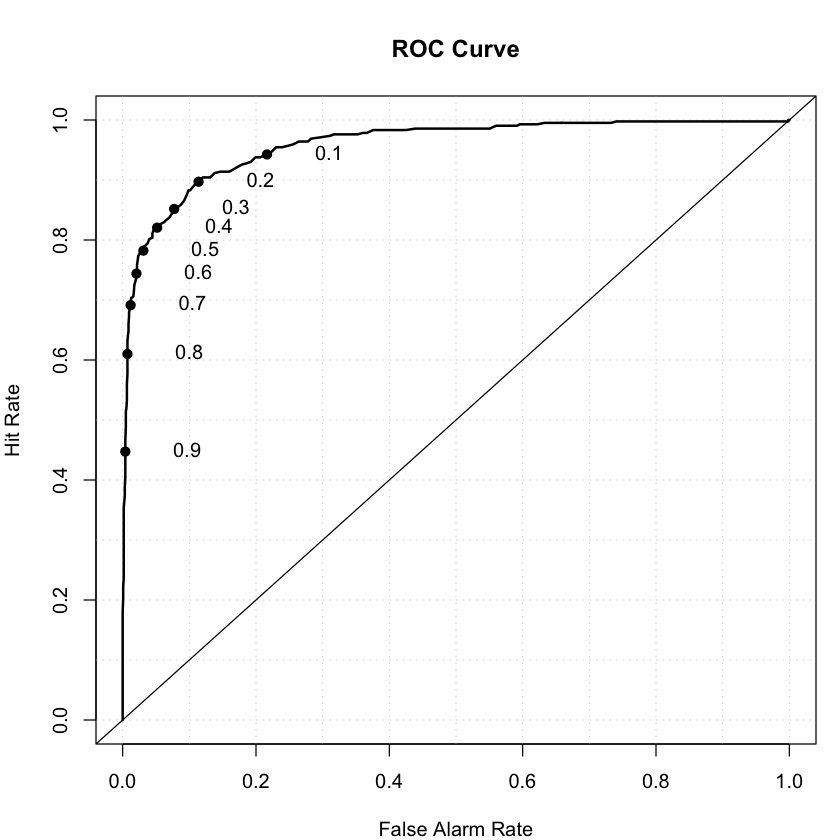

In [79]:
## Best AUC using just one attribute
training_attributes <-c(7, 12)  # total_sulfur_dioxide
wineModel <- glm(red ~ ., family=binomial(link='logit'), data=trainingData[,training_attributes])
wineModel.predictions <- predict(wineModel, newdata=testData, type='response')
wineModel.roc <- roc.plot(testData$red, wineModel.predictions)

cm <- ConfusionMatrix(testData$red, wineModel.predictions, seq(0.0,1.0,0.1))
cm$accuracy <- (cm$TP + cm$TN) / (cm$TP + cm$TN + cm$FP + cm$FN)
cm

paste("Mean Accuracy:", mean(cm$accuracy) )
paste('AUC:', wineModel.roc$roc.vol['Area'] )

paste('Summary of Model:')
summary(wineModel)

## Using all Attributes

Warning message:
In roc.plot.default(testData$red, wineModel.predictions): Large amount of unique predictions used as thresholds. Consider specifying thresholds.

,threshold,TP,TN,FP,FN,accuracy
1,0,418,0,1256,0,0.2497013
2,0.1,414,1236,20,4,0.9856631
3,0.2,414,1245,11,4,0.9910394
4,0.3,413,1251,5,5,0.9940263
5,0.4,411,1253,3,7,0.9940263
6,0.5,411,1254,2,7,0.9946237
7,0.6,410,1254,2,8,0.9940263
8,0.7,406,1254,2,12,0.9916368
9,0.8,405,1254,2,13,0.9910394
10,0.9,394,1256,0,24,0.9856631


[1] "Mean Accuracy: 0.901976756815467"

[1] "AUC: 0.995927681102002"

[1] "Summary of Model:"


Call:
glm(formula = red ~ ., family = binomial(link = "logit"), data = trainingData[, 
    training_attributes])

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-4.1412  -0.0494  -0.0125  -0.0005   5.8034  

Coefficients:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          -14.4465     1.4273 -10.122  < 2e-16 ***
fixed_acidity         -2.6332     3.2935  -0.800 0.423992    
volatile_acidity       9.9467     1.8234   5.455 4.89e-08 ***
citric_acid           -3.8869     2.2037  -1.764 0.077767 .  
residual_sugar       -65.1471     9.1327  -7.133 9.80e-13 ***
chlorides             14.0381     2.7140   5.172 2.31e-07 ***
free_sulfur_dioxide   19.1429     4.3176   4.434 9.26e-06 ***
total_sulfur_dioxide -23.4138     2.4926  -9.393  < 2e-16 ***
density               83.1708    11.2108   7.419 1.18e-13 ***
pH                    -0.4443     2.1196  -0.210 0.833966    
sulphates              8.5882     2.5572   3.358 0.000784 ***
alcohol      

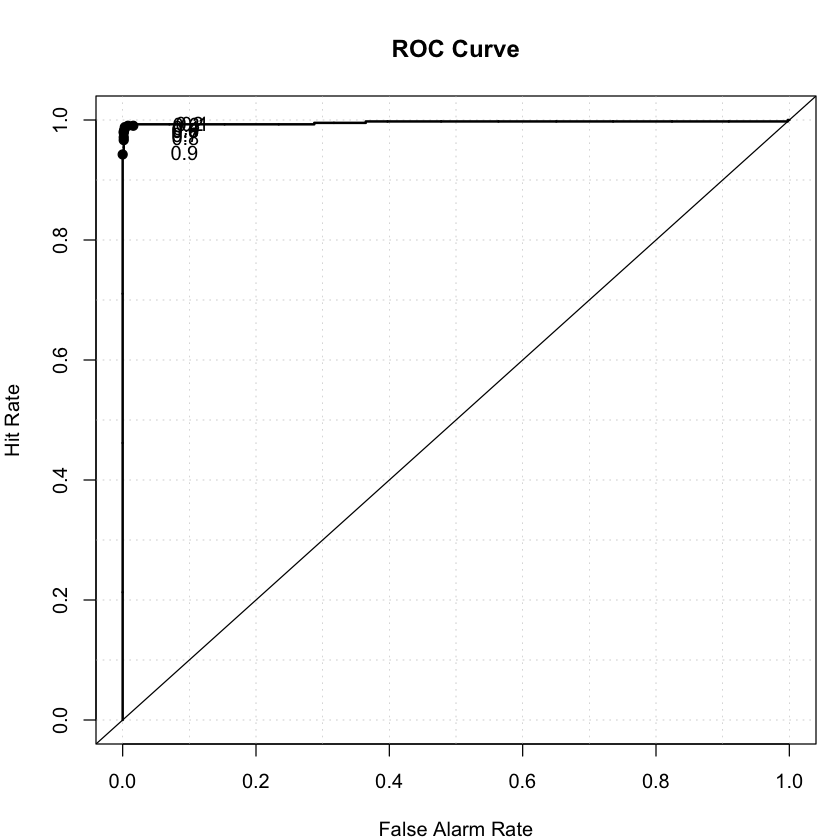

In [57]:
training_attributes <- 1:12  # using all attributes
wineModel <- glm(red ~ ., family=binomial(link='logit'), data=trainingData[,training_attributes])
wineModel.predictions <- predict(wineModel, newdata=testData, type='response')
wineModel.roc <- roc.plot(testData$red, wineModel.predictions)

cm <- ConfusionMatrix(testData$red, wineModel.predictions, seq(0.0,1.0,0.1))
cm$accuracy <- (cm$TP + cm$TN) / (cm$TP + cm$TN + cm$FP + cm$FN)
cm

paste("Mean Accuracy:", mean(cm$accuracy) )
paste('AUC:', wineModel.roc$roc.vol['Area'] )

paste('Summary of Model:')
summary(wineModel)

## Experimenting using just one attribute at a time (sorted from best to worst AUC)

[1] "AUC: 0.958570155121446"

[1] "Mean Accuracy: 0.822091886608016"

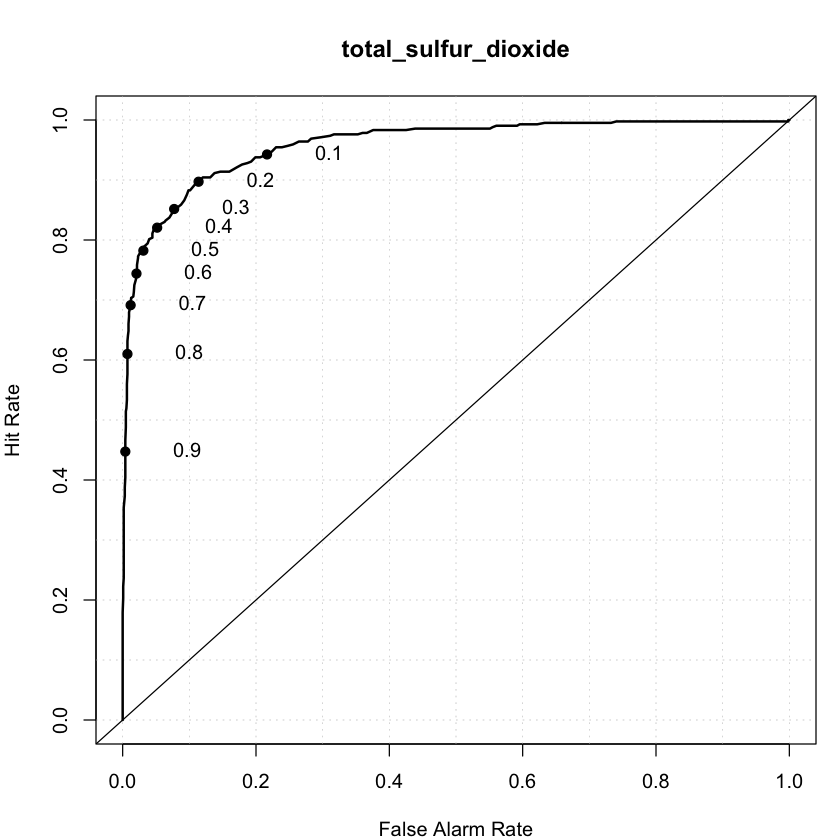

In [60]:
# total_sulfur_dioxide
training_attributes <-c(7, 12)  
wineModel <- glm(red ~ ., family=binomial(link='logit'), data=trainingData[,training_attributes])
wineModel.predictions <- predict(wineModel, newdata=testData, type='response')
wineModel.roc <- roc.plot(testData$red, wineModel.predictions, main="total_sulfur_dioxide")

cm <- ConfusionMatrix(testData$red, wineModel.predictions, seq(0.0,1.0,0.1))
cm$accuracy <- (cm$TP + cm$TN) / (cm$TP + cm$TN + cm$FP + cm$FN)

paste('AUC:', wineModel.roc$roc.vol['Area'] )
paste("Mean Accuracy:", mean(cm$accuracy) )

[1] "AUC: 0.905990003961844"

[1] "Mean Accuracy: 0.766427718040621"

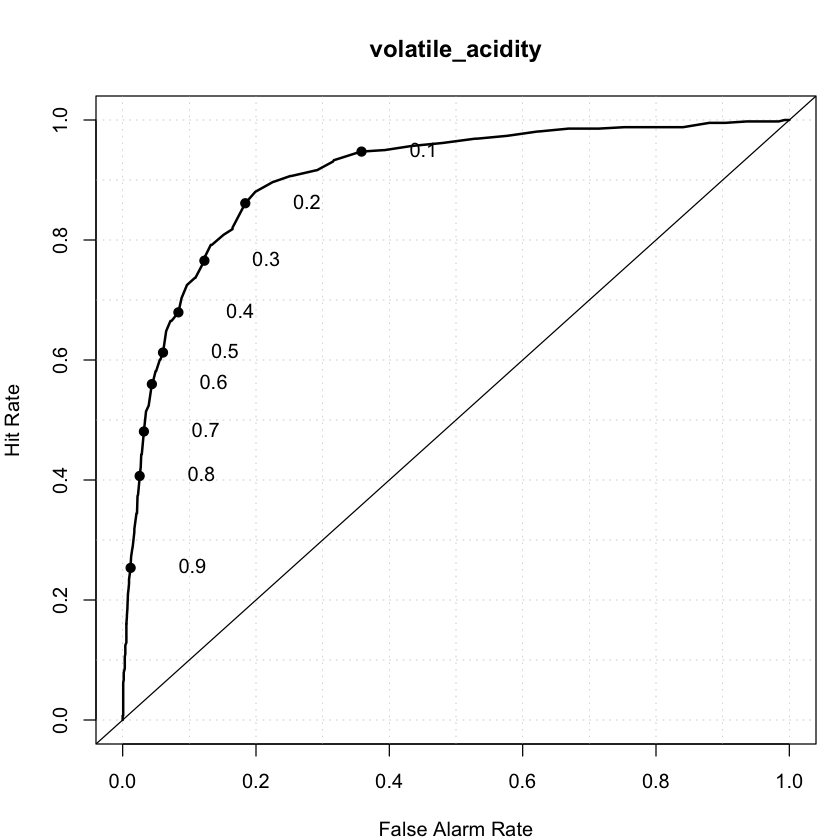

In [61]:
# volatile_acidity
training_attributes <-c(2, 12)  
wineModel <- glm(red ~ ., family=binomial(link='logit'), data=trainingData[,training_attributes])
wineModel.predictions <- predict(wineModel, newdata=testData, type='response')
wineModel.roc <- roc.plot(testData$red, wineModel.predictions, main="volatile_acidity")

cm <- ConfusionMatrix(testData$red, wineModel.predictions, seq(0.0,1.0,0.1))
cm$accuracy <- (cm$TP + cm$TN) / (cm$TP + cm$TN + cm$FP + cm$FN)

paste('AUC:', wineModel.roc$roc.vol['Area'] )
paste("Mean Accuracy:", mean(cm$accuracy) )

[1] "AUC: 0.774949143632097"

[1] "Mean Accuracy: 0.703975236233301"

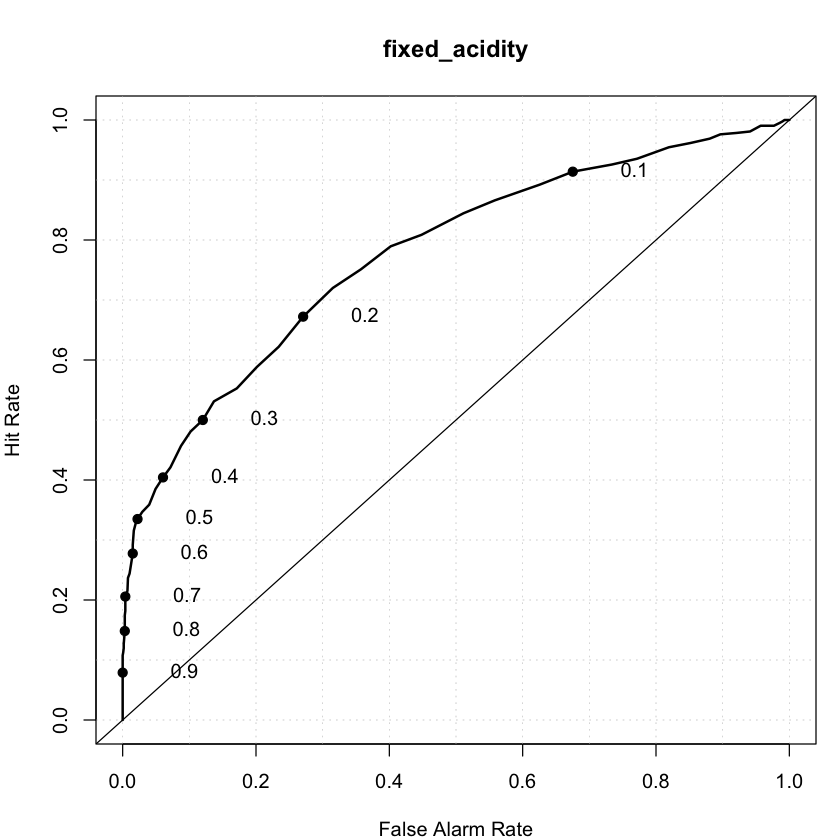

In [62]:
# fixed_acidity
training_attributes <-c(1, 12)  
wineModel <- glm(red ~ ., family=binomial(link='logit'), data=trainingData[,training_attributes])
wineModel.predictions <- predict(wineModel, newdata=testData, type='response')
wineModel.roc <- roc.plot(testData$red, wineModel.predictions, main="fixed_acidity")

cm <- ConfusionMatrix(testData$red, wineModel.predictions, seq(0.0,1.0,0.1))
cm$accuracy <- (cm$TP + cm$TN) / (cm$TP + cm$TN + cm$FP + cm$FN)

paste('AUC:', wineModel.roc$roc.vol['Area'] )
paste("Mean Accuracy:", mean(cm$accuracy) )

[1] "AUC: 0.619286753725658"

[1] "Mean Accuracy: 0.633594004561747"

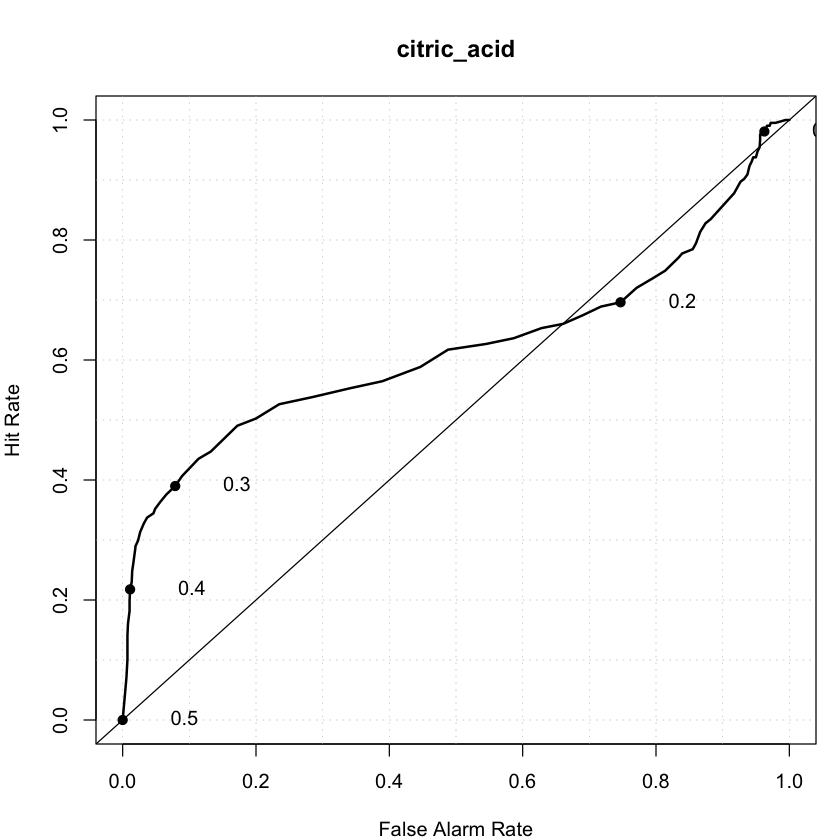

In [64]:
# citric_acid
training_attributes <-c(3, 12)  
wineModel <- glm(red ~ ., family=binomial(link='logit'), data=trainingData[,training_attributes])
wineModel.predictions <- predict(wineModel, newdata=testData, type='response')
wineModel.roc <- roc.plot(testData$red, wineModel.predictions, main="citric_acid")

cm <- ConfusionMatrix(testData$red, wineModel.predictions, seq(0.0,1.0,0.1))
cm$accuracy <- (cm$TP + cm$TN) / (cm$TP + cm$TN + cm$FP + cm$FN)

paste('AUC:', wineModel.roc$roc.vol['Area'] )
paste("Mean Accuracy:", mean(cm$accuracy) )

Warning message:
: glm.fit: fitted probabilities numerically 0 or 1 occurred

[1] "AUC: 0.940267576875019"

[1] "Mean Accuracy: 0.761322906484197"

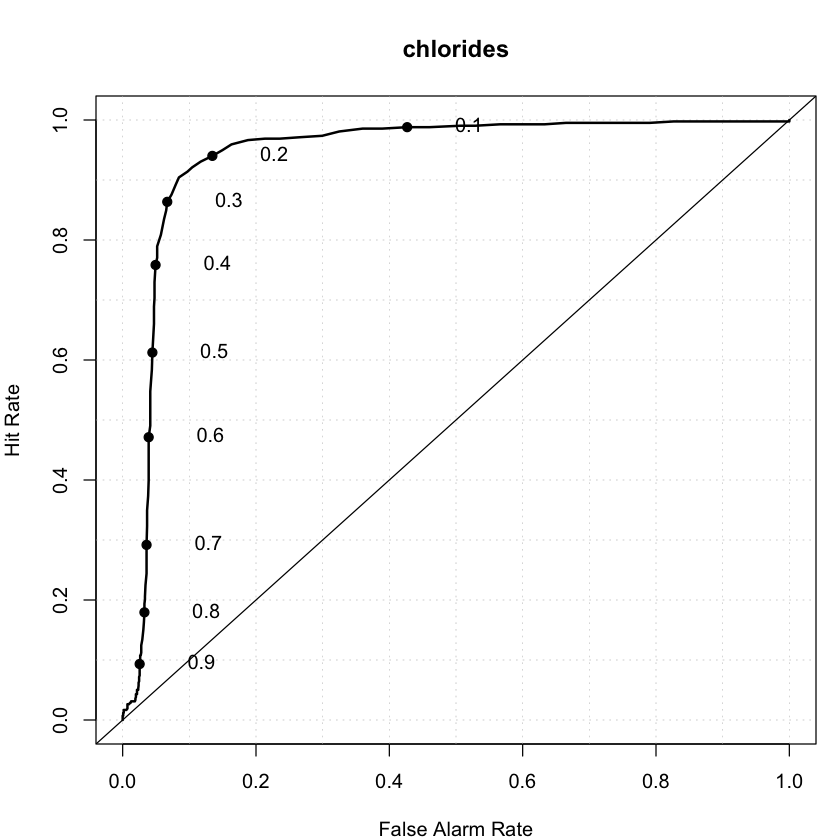

In [65]:
# chlorides
training_attributes <-c(5, 12)  
wineModel <- glm(red ~ ., family=binomial(link='logit'), data=trainingData[,training_attributes])
wineModel.predictions <- predict(wineModel, newdata=testData, type='response')
wineModel.roc <- roc.plot(testData$red, wineModel.predictions, main="chlorides")

cm <- ConfusionMatrix(testData$red, wineModel.predictions, seq(0.0,1.0,0.1))
cm$accuracy <- (cm$TP + cm$TN) / (cm$TP + cm$TN + cm$FP + cm$FN)

paste('AUC:', wineModel.roc$roc.vol['Area'] )
paste("Mean Accuracy:", mean(cm$accuracy) )

Warning message:
: glm.fit: fitted probabilities numerically 0 or 1 occurred

[1] "AUC: 0.854840307195319"

[1] "Mean Accuracy: 0.713370261757359"

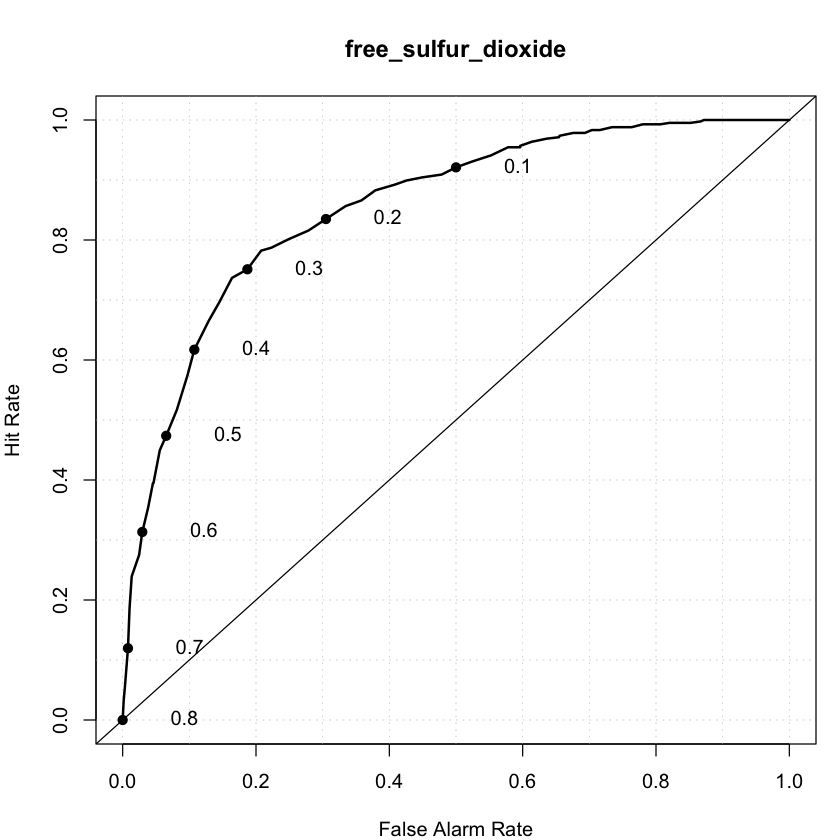

In [66]:
# free_sulfur_dioxide
training_attributes <-c(6, 12)  
wineModel <- glm(red ~ ., family=binomial(link='logit'), data=trainingData[,training_attributes])
wineModel.predictions <- predict(wineModel, newdata=testData, type='response')
wineModel.roc <- roc.plot(testData$red, wineModel.predictions, main="free_sulfur_dioxide")

cm <- ConfusionMatrix(testData$red, wineModel.predictions, seq(0.0,1.0,0.1))
cm$accuracy <- (cm$TP + cm$TN) / (cm$TP + cm$TN + cm$FP + cm$FN)

paste('AUC:', wineModel.roc$roc.vol['Area'] )
paste("Mean Accuracy:", mean(cm$accuracy) )

[1] "AUC: 0.828886416968884"

[1] "Mean Accuracy: 0.698924731182796"

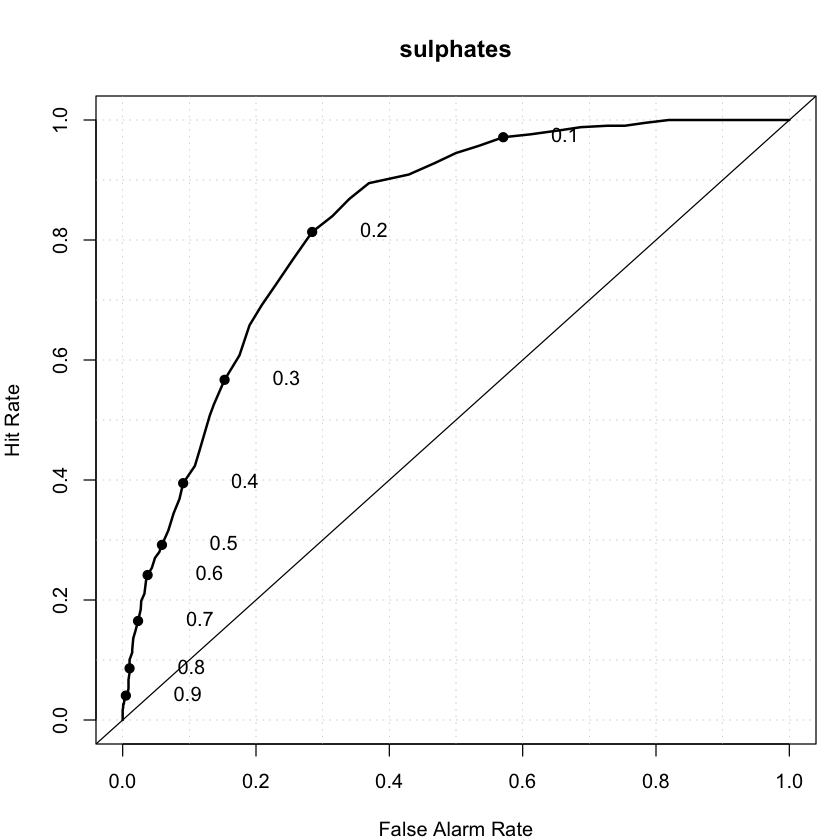

In [67]:
# sulphates
training_attributes <-c(10, 12)  
wineModel <- glm(red ~ ., family=binomial(link='logit'), data=trainingData[,training_attributes])
wineModel.predictions <- predict(wineModel, newdata=testData, type='response')
wineModel.roc <- roc.plot(testData$red, wineModel.predictions, main="sulphates")

cm <- ConfusionMatrix(testData$red, wineModel.predictions, seq(0.0,1.0,0.1))
cm$accuracy <- (cm$TP + cm$TN) / (cm$TP + cm$TN + cm$FP + cm$FN)

paste('AUC:', wineModel.roc$roc.vol['Area'] )
paste("Mean Accuracy:", mean(cm$accuracy) )

[1] "AUC: 0.763621697193186"

[1] "Mean Accuracy: 0.665906375583795"

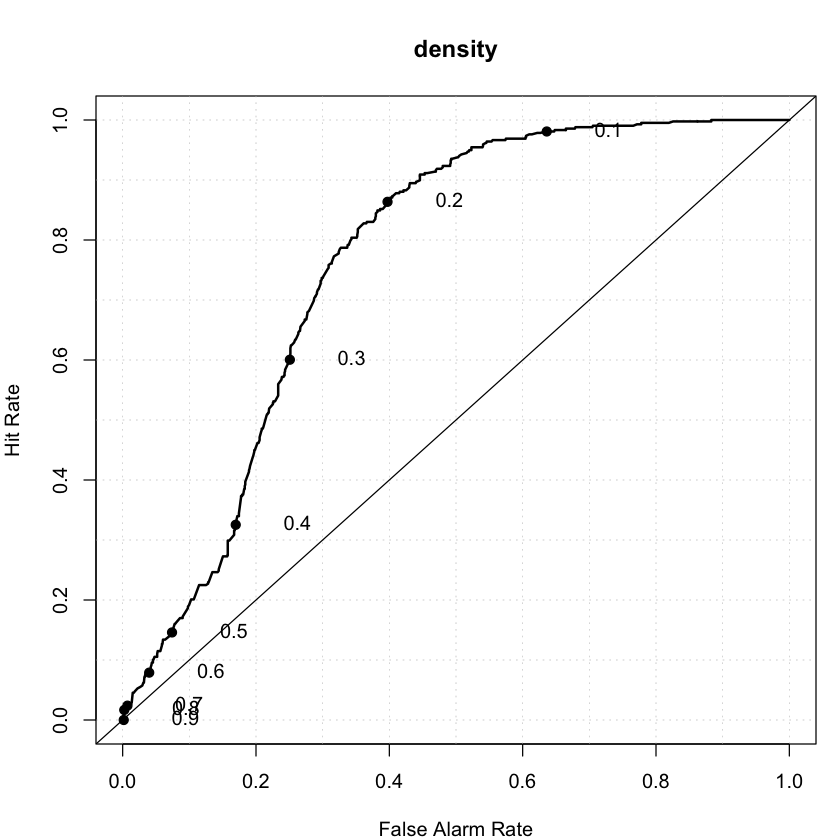

In [68]:
# density
training_attributes <-c(8, 12)  
wineModel <- glm(red ~ ., family=binomial(link='logit'), data=trainingData[,training_attributes])
wineModel.predictions <- predict(wineModel, newdata=testData, type='response')
wineModel.roc <- roc.plot(testData$red, wineModel.predictions, main="density")

cm <- ConfusionMatrix(testData$red, wineModel.predictions, seq(0.0,1.0,0.1))
cm$accuracy <- (cm$TP + cm$TN) / (cm$TP + cm$TN + cm$FP + cm$FN)

paste('AUC:', wineModel.roc$roc.vol['Area'] )
paste("Mean Accuracy:", mean(cm$accuracy) )

[1] "AUC: 0.750314280925243"

[1] "Mean Accuracy: 0.655913978494624"

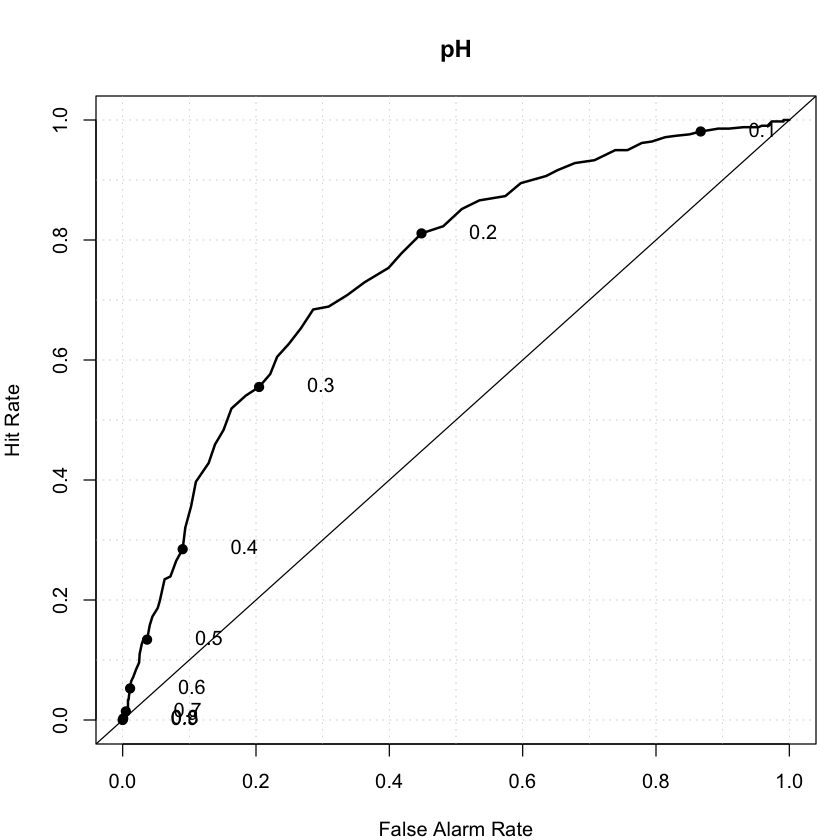

In [69]:
# pH
training_attributes <-c(9, 12)  
wineModel <- glm(red ~ ., family=binomial(link='logit'), data=trainingData[,training_attributes])
wineModel.predictions <- predict(wineModel, newdata=testData, type='response')
wineModel.roc <- roc.plot(testData$red, wineModel.predictions, main="pH")

cm <- ConfusionMatrix(testData$red, wineModel.predictions, seq(0.0,1.0,0.1))
cm$accuracy <- (cm$TP + cm$TN) / (cm$TP + cm$TN + cm$FP + cm$FN)

paste('AUC:', wineModel.roc$roc.vol['Area'] )
paste("Mean Accuracy:", mean(cm$accuracy) )

[1] "AUC: 0.672564037119434"

[1] "Mean Accuracy: 0.655696752470946"

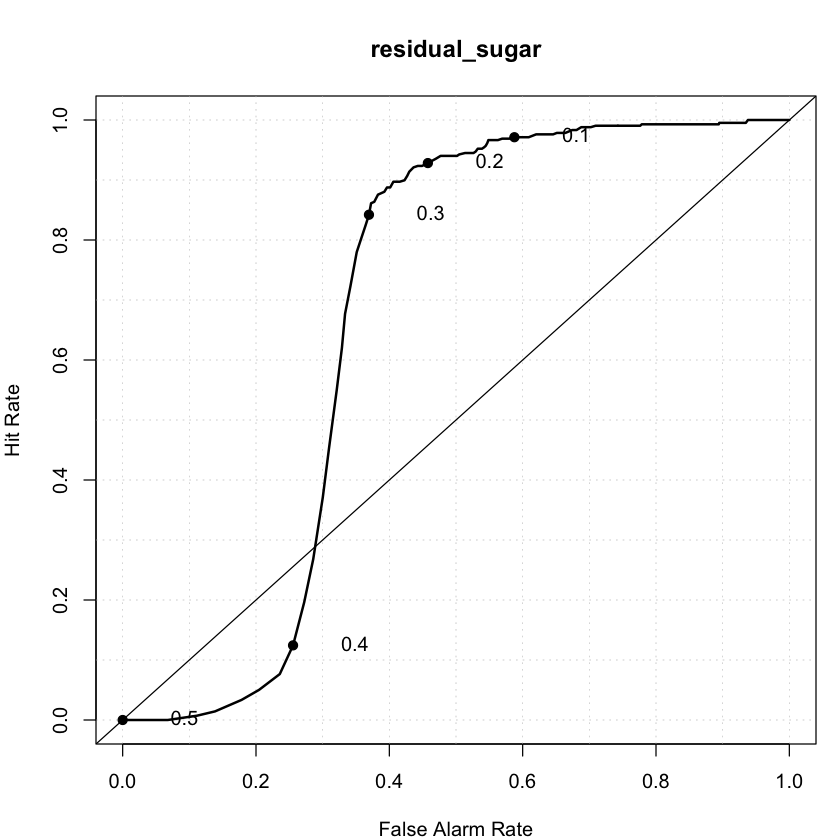

In [70]:
# residual_sugar
training_attributes <-c(4, 12)  
wineModel <- glm(red ~ ., family=binomial(link='logit'), data=trainingData[,training_attributes])
wineModel.predictions <- predict(wineModel, newdata=testData, type='response')
wineModel.roc <- roc.plot(testData$red, wineModel.predictions, main="residual_sugar")

cm <- ConfusionMatrix(testData$red, wineModel.predictions, seq(0.0,1.0,0.1))
cm$accuracy <- (cm$TP + cm$TN) / (cm$TP + cm$TN + cm$FP + cm$FN)

paste('AUC:', wineModel.roc$roc.vol['Area'] )
paste("Mean Accuracy:", mean(cm$accuracy) )

[1] "AUC: 0.480338394843507"

[1] "Mean Accuracy: 0.614641033995873"

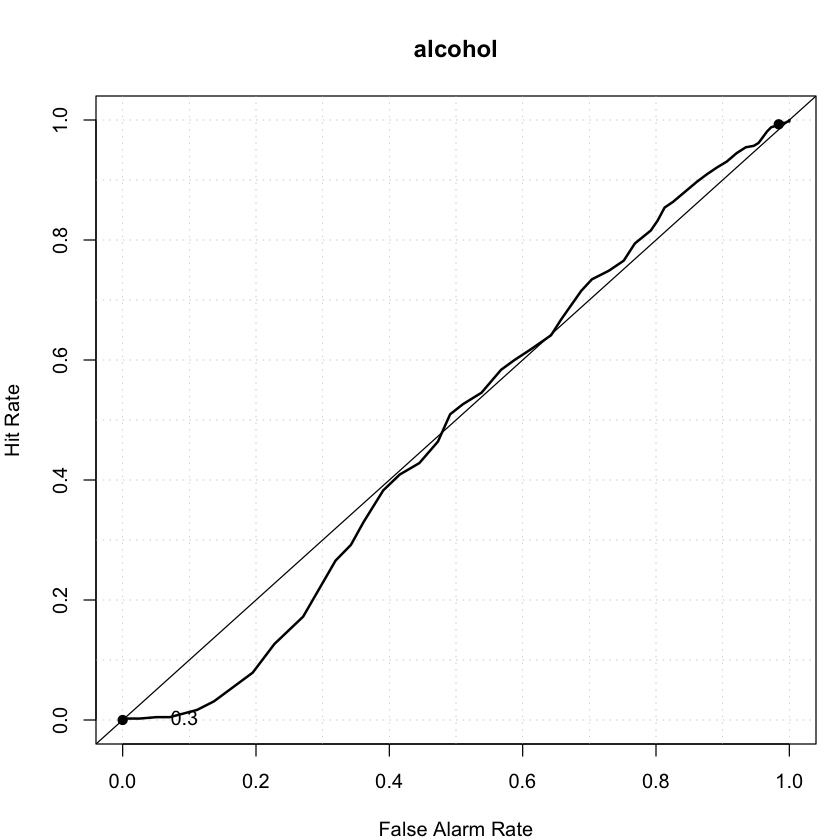

In [71]:
# alcohol
training_attributes <-c(11, 12)  
wineModel <- glm(red ~ ., family=binomial(link='logit'), data=trainingData[,training_attributes])
wineModel.predictions <- predict(wineModel, newdata=testData, type='response')
wineModel.roc <- roc.plot(testData$red, wineModel.predictions, main="alcohol")

cm <- ConfusionMatrix(testData$red, wineModel.predictions, seq(0.0,1.0,0.1))
cm$accuracy <- (cm$TP + cm$TN) / (cm$TP + cm$TN + cm$FP + cm$FN)

paste('AUC:', wineModel.roc$roc.vol['Area'] )
paste("Mean Accuracy:", mean(cm$accuracy) )